### Allele Frequency Trajectories

In [1]:
import numpy as np
import os as os
import sys as sys
import multiprocessing as mp
import pandas as pd
import socket
import matplotlib.pyplot as plt
from itertools import groupby
from shutil import which
import os
import re as re
from matplotlib import gridspec
from matplotlib.dates import date2num
from datetime import date

### Pick the right path (whether on cluster or at home)

socket_name = socket.gethostname()
print(f"Current machine: {socket_name}")
if socket_name == "DESKTOP-5RJD9NC":
    path = "/gitProjects/covid19_data"   # The Path on Harald's machine
if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/covid19_data/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
### For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)
rcParams['axes.linewidth'] = 0.2  # Set the Default Size of the Boundary for small 2.25in width figures
    
### Check whether required bins are available
req_bins = ["mafft"] 
for b in req_bins:
    s = which(b)
    if not s:
        print(f"Make sure to install {b} and have in path. I cannot find it!")
        
os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd())

sys.path.append("./python3/")
from manipulate_fasta import fasta_iter_raw, fasta_iter

Current machine: compute-a-16-64.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/covid19_data


### Define Functions

In [2]:
def load_merged_df(var_path="./output/tables/derived_common_snps.tsv",
                   meta_path="./data/apr20/metadata.tsv",
                   epi_col = "gisaid_epi_isl", merge_col="iid"):
    """Load variant df and meta df, and merge on epi_col"""
    df = pd.read_csv(var_path, sep="\t")
    #df[epi_col] = df["iid"].str.split("|").str[1]  # Split out the EPI ID in oldcycle
    df_meta = pd.read_csv(meta_path, sep="\t")
    df_meta["iid"] = df_meta["strain"].str.replace("/", "|")
    df1 = pd.merge(df, df_meta, on=merge_col)
    print(f"Merged to {len(df1)}/{len(df)} Individuals")
    return df1

### Load the variant Data

In [3]:
df1 = load_merged_df(var_path="./output/tables/derived_common_snps_oct20.tsv",
                     meta_path="./data/oct20/metadata_2020-10-30_17-42.tsv.gz")
df1 = df1[~(df1["date"]=="2020-02-XX")].copy() # Throw out garbage data
df1 = df1[~(df1["date"]=="2020-01-XX")].copy() # Throw out garbage data
df1 = df1[~(df1["date"]=="2020-03-XX")].copy() # Throw out garbage data
df1 = df1[~(df1["date"]=="2020-01-01")].copy()
df1["date1"] =  pd.to_datetime(df1["date"]) # New Sort Column
print(f"Thrown out data with inaccurate dates, now: {len(df1)}")

Merged to 165471/165610 Individuals
Thrown out data with inaccurate dates, now: 165446


### Experiments to establish what is missing [Only run if many individuals do not match meta]

In [ ]:
df = pd.read_csv("./output/tables/derived_common_snps.tsv", sep="\t")
idx =[iid not in df1["iid"].values for iid in df["iid"]]

cts = df[idx]["iid"].str.split("/").str[1]
cts.value_counts()

#df_meta = pd.read_csv("./data/may20/metadata.tsv", sep="\t")
#found = df_meta["gisaid_epi_isl"].str.contains("433498")
#np.sum(found)

### Plot Overall Frequency

In [5]:
df2 = df1.copy()
pos= f"23402"
flip = True

df2 = df2[df2["date1"]!="2020-01-01"]
df2 = df2.sort_values(by="date1")
df2 = df2[df2['host']=="Human"]
print(f"Human Samples: {len(df2)}")
derived = df2[pos]

if flip:
    derived= ~derived

dts = df2["date1"]
cum_count = np.arange(len(df2))+1
cum_der = np.cumsum(derived)
all_freq = cum_der / cum_count

Human Samples: 163447


Saved to ./figures/dumpster/all_freq_full_octv1.png


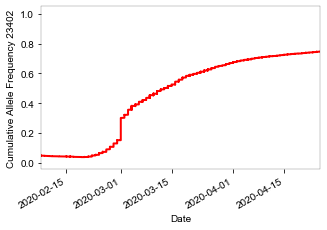

In [6]:
savepath="./figures/dumpster/all_freq_full_octv1.png"

plt.figure(figsize=(5,3))
ax=plt.gca()
ax.plot(dts, all_freq, lw=2, c="r")

ax.set_ylabel(f"Cumulative Allele Frequency {23402}")
ax.set_xlabel("Date")
plt.xticks(rotation=30, ha='right')
#ax.set_xlim([date("2020-02-01"), date("2020-04-01")])
ax.set_xlim([date(2020, 2, 8), date(2020, 4, 25)])
if len(savepath)>0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=200)
    print(f"Saved to {savepath}")

plt.show()

# Plot Diagrams per region/country

In [7]:
def plot_freq_traj_ax(ax, df, ctry, pos= f"23402", xlim=[], left=True, bottom=True, c="red", cs=["blue", "red"],
                      flip=False, min_cases = 10, col = "country", ylabel="Cumulative Frequency Derived",
                      hist=True, ylim=[], lw=3, fs_l=12, show=False, hist_bw=3, alpha=0.5,
                      ylim_hist=[0,0.15], lw_hist=0.3, hist_y_stretch=1.2,
                      txt_xy=(0.97, 0.48), savepath=""):
    plt.xticks(rotation=30, ha='right')
    df_t = df[df[col]==ctry]
    
    dts = df_t["date1"].values
    derived = df_t[pos].values.astype("bool")
    if flip:
        derived = 1 - derived
    idx = (derived == 1)  # Get index of derived dates
    
    cum_count = np.arange(len(df_t))+1
    cum_der = np.cumsum(derived)
    all_freq = cum_der / cum_count
    
    ax.set_yticks([0,0.25,0.5, 0.75])
    #plt.plot(date, cum_count)
        
    ax.set_xlim(xlim)
    if len(ylim)>0:
        ax.set_ylim(ylim)
    #ax.legend(fontsize=fs_l)
    label = f"{ctry}\n {np.sum(derived)}/{len(derived)}"
    ax.text(txt_xy[0], txt_xy[1], label, horizontalalignment='right', zorder=10,
            verticalalignment='top', transform=ax.transAxes, fontsize=fs_l)
    ax.grid(linestyle='--', lw=0.5)
    
    if hist_bw>0:
        bins = pd.date_range(xlim[0], xlim[1])[::hist_bw]
        ax2=ax.twinx()
        ax2.set_ylim(ylim_hist)
        ax2.set_yticks([])
        n,_,_ = ax2.hist([dts[idx], dts[~idx]], range=xlim, lw=lw_hist,
                  bins=date2num(bins), ec="k", alpha=alpha, color=cs, zorder=0)
        m = hist_y_stretch * np.max(n[0]+n[1])
        ax2.set_ylim([0,m])
        
    ax.plot(dts[min_cases:], all_freq[min_cases:], label=ctry, 
            lw=lw, color=c, zorder=5) # Plot the line
    
    ### Do the labels
    if left:
        ax.set_ylabel(ylabel, color=c)
        ax.tick_params(axis='y', colors=c)
    else:
        ax.set_yticklabels([])
    
    if bottom:
        ax.set_xlabel("Date")
        
    else: 
        ax.set_xticklabels([])

    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', 
                    pad_inches = 0, dpi=200)
        print(f"Saved to {savepath}")
    if show:
        plt.show()
        
        
def array_freqs(
    df, countries, pos= "23402", min_cases=20,
    n_col =6, n_row = 4, alpha=1.0,
    hspace = 0.08, wspace = 0.08, ylabel="Cumulative Frequency Derived",
    sgl_figsize=(3,3), lw=4, hist_bw=3,
    xlim = [date(2020, 2, 15), date(2020, 4, 30)], ylim=[0,1],
    only_first=False, col = "country", fs_l = 12, flip=False,
    txt_xy=(0.97, 0.48), ylim_hist=[0,0.15], c="red", cs = ["blue", "red"],
    
    savepath=""):
    """Make array Plot of allele Frequencies"""

    figsize = (n_col * sgl_figsize[0], n_row * sgl_figsize[1])
    plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(n_row, n_col)
    gs.update(hspace = hspace) # set the spacing between axes.
    gs.update(wspace = wspace)

    n=len(countries)  # Keep the original Length 
    cts = np.resize(countries, (n_row, n_col))
    #labels = np.resize(labels, (n_row, n_col))

    for i in range(n_row):
        for j in range(n_col):
            left = False
            bottom = False
            if i == len(cts)-1:
                bottom=True
            if j== 0:
                left=True
            if (i>0 or j>0) and only_first:
                continue
            #print((i,j))
            country = cts[i,j]
            if (n_col*i + j)>=n: # If no more new data to plot
                continue
            ax = plt.subplot(gs[i , j]) # The left subplot
            plot_freq_traj_ax(ax, df, ctry=country, pos=pos, xlim=xlim, ylim=ylim, fs_l=fs_l, flip=flip,
                              col = col, left=left, bottom=bottom, lw=lw, txt_xy=txt_xy, c=c, cs=cs,
                              ylim_hist=ylim_hist, hist_bw=hist_bw, alpha=alpha, min_cases=min_cases,
                              ylabel=ylabel)
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', 
                    pad_inches = 0, dpi=300)
        print(f"Saved to {savepath}")
    plt.show()

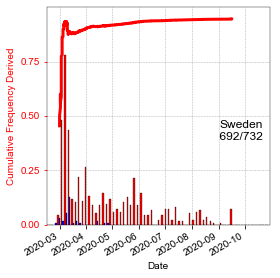

In [8]:
xlim = [date(2020, 2, 15), date(2020, 10, 30)]
ylim=[0,1]
ctry = "Sweden"

fig = plt.figure(figsize=(4,4))
ax = plt.gca()
plot_freq_traj_ax(ax, df2, ctry=ctry, xlim=xlim,
                  c="red", cs=["red", "blue"], 
                  hist_bw=4, alpha=1.0,
                  ylim=ylim, fs_l=12, flip=True)

In [9]:
countries = list(df2["country"].value_counts()[:25].index)
#countries
#df2["country"].value_counts()[:30]

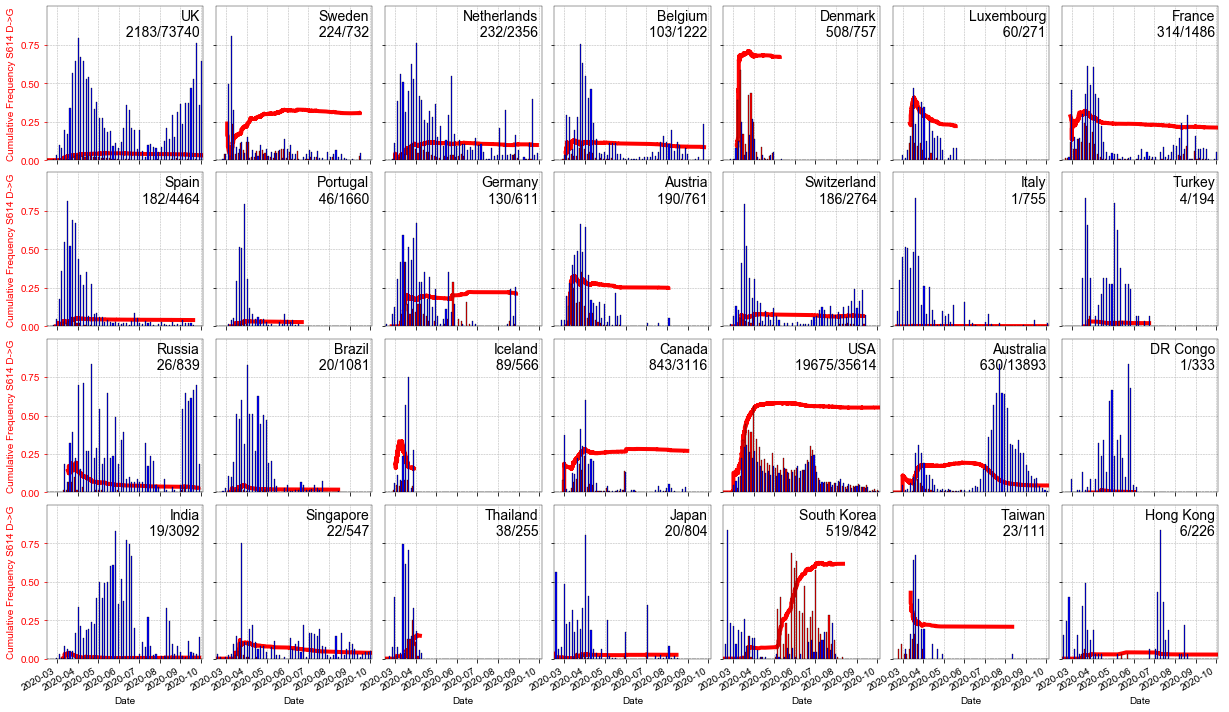

In [20]:
dct_rpl = {"Democratic Republic of the Congo": "DR Congo", "United Kingdom":"UK"}
df2["country"].replace(dct_rpl, inplace=True)

countries = ["UK", "Sweden", "Netherlands", "Belgium", "Denmark", "Luxembourg", "France", "Spain", "Portugal", 
             "Germany", "Austria", "Switzerland", "Italy",
             "Turkey", "Russia",  "Brazil", "Iceland", "Canada", "USA", "Australia", "DR Congo", 
             "India", "Singapore", "Thailand", "Japan", "South Korea", "Taiwan", "Hong Kong", "China"]

array_freqs(df=df2, pos=f"1058", flip=False, #23402  #1162 Australian variant 13535 British
            countries=countries, 
            xlim = [date(2020, 2, 15), date(2020, 10, 5)],
            txt_xy=(0.98, 0.98), #23402 #35  # Washington Clade
            n_row=4, n_col=7, 
            fs_l=14, lw=4, c="red", cs=["red", "blue"], hist_bw=4,
            ylabel="Cumulative Frequency S614 D->G",  # "Cumulative Frequency S614 D->G"
            savepath="") # ./figures/allele_frequencies/S614_world_oct.png

Saved to ./figures/allele_frequencies/S614_us_oct.png


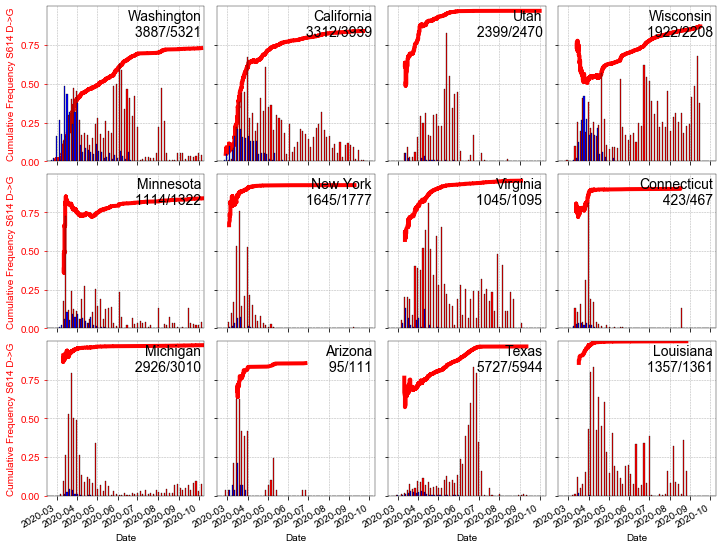

In [13]:
regions = ["Washington", "California", "Utah", "Wisconsin", 
           "Minnesota", "New York", "Virginia", "Connecticut", 
           "Michigan", "Arizona", "Texas", "Louisiana"]

array_freqs(df=df2, countries=regions, col="division", fs_l=14, lw=4, 
            xlim = [date(2020, 2, 15), date(2020, 10, 10)],
            pos=f"23402", flip=True,   #1058: US Mutation # 17857: Washington Mutation, # 23402
            c="red", cs=["red", "blue"], hist_bw=4,
            n_row = 3, n_col =4, txt_xy=(0.98, 0.98), only_first=False,
            ylabel="Cumulative Frequency S614 D->G",
            savepath="./figures/allele_frequencies/S614_us_oct.png") # ./figures/dumpster/arr_us.png

In [ ]:
df2["country"].value_counts()[:50]
#df2["division"].value_counts()[:50]

### Plot UK

Saved to ./figures/dumpster/arr_uk.png


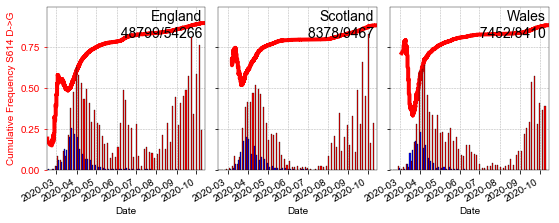

In [16]:
regions = ["England","Scotland", "Wales"]

array_freqs(df=df2, countries=regions, col="division", fs_l=14, lw=4, 
            xlim = [date(2020, 2, 15), date(2020, 10, 15)],
            pos="23402", # 23402
            c="red", cs=["red", "blue"], hist_bw=4,
            n_col =3, n_row = 1, txt_xy=(0.98, 0.98), only_first=False,
            ylabel="Cumulative Frequency S614 D->G", flip=True,
            savepath="./figures/dumpster/arr_uk.png") # ./figures/dumpster/arr_us.png

# Check out Variants

In [17]:
df = pd.read_csv("./output/tables/variant_maf_oct.tsv", sep="\t")

In [18]:
df.sort_values(by="maf", ascending=False)

,refcount,altcount,ref,alt,pos,totcount,maf
69,98189,65202,g,a,28880,163391,0.399055
70,98525,65085,g,a,28881,163610,0.397806
71,98551,65087,g,c,28882,163638,0.397750
54,127774,37270,g,t,25562,165044,0.225819
4,137357,27442,c,t,1058,164799,0.166518
...,...,...,...,...,...,...,...
29,163463,1896,t,c,17246,165359,0.011466
40,160329,1815,c,t,21574,162144,0.011194
64,163467,1765,c,t,28310,165232,0.010682
15,158475,1673,c,t,8682,160148,0.010447


Human Samples: 118420
Saved to ./figures/dumpster/all_freqs_oct/240.png


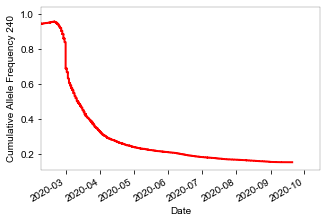

Saved to ./figures/dumpster/all_freqs_oct/312.png


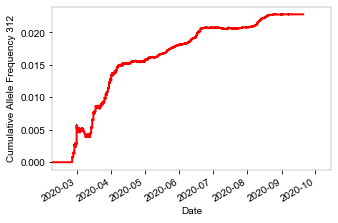

Saved to ./figures/dumpster/all_freqs_oct/444.png


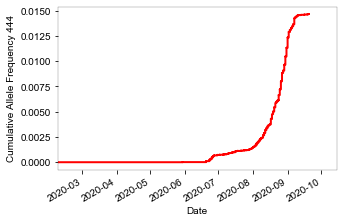

Saved to ./figures/dumpster/all_freqs_oct/1058.png


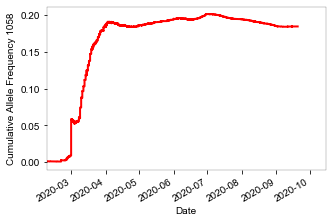

Saved to ./figures/dumpster/all_freqs_oct/1162.png


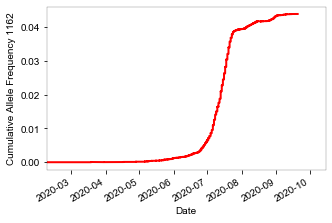

Saved to ./figures/dumpster/all_freqs_oct/1439.png


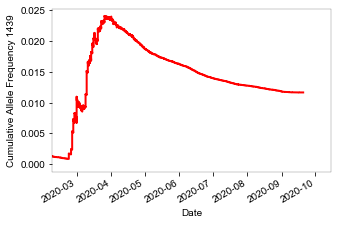

Saved to ./figures/dumpster/all_freqs_oct/2415.png


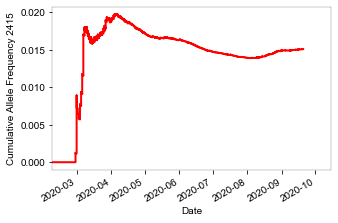

Saved to ./figures/dumpster/all_freqs_oct/2479.png


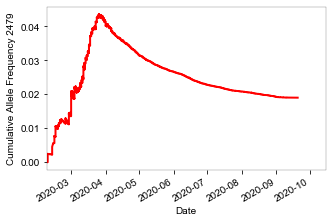

Saved to ./figures/dumpster/all_freqs_oct/2557.png


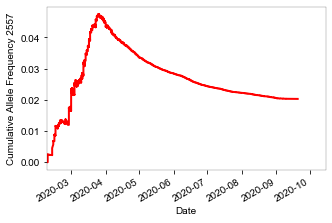

Saved to ./figures/dumpster/all_freqs_oct/2890.png


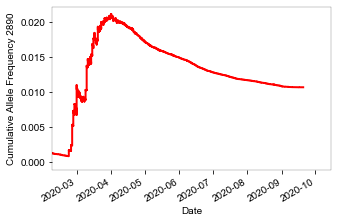

Saved to ./figures/dumpster/all_freqs_oct/3036.png


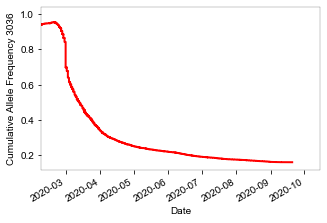

Saved to ./figures/dumpster/all_freqs_oct/4001.png


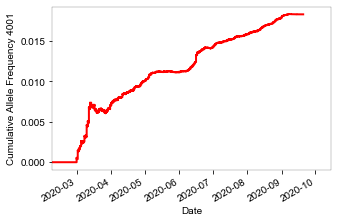

Saved to ./figures/dumpster/all_freqs_oct/6285.png


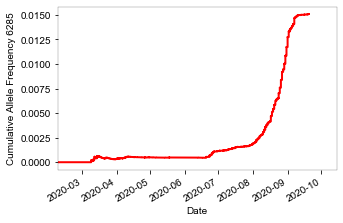

Saved to ./figures/dumpster/all_freqs_oct/6311.png


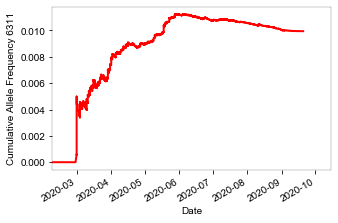

Saved to ./figures/dumpster/all_freqs_oct/7539.png


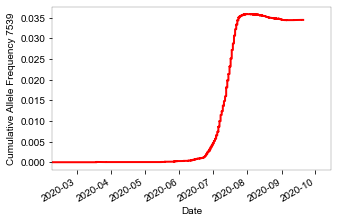

Saved to ./figures/dumpster/all_freqs_oct/8781.png


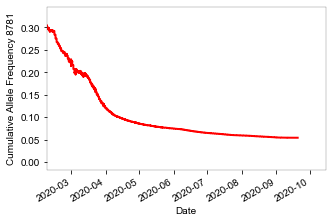

Saved to ./figures/dumpster/all_freqs_oct/9476.png


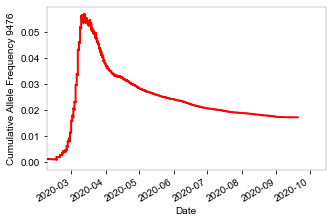

Saved to ./figures/dumpster/all_freqs_oct/10096.png


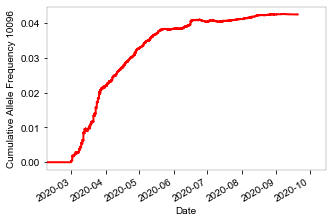

Saved to ./figures/dumpster/all_freqs_oct/10318.png


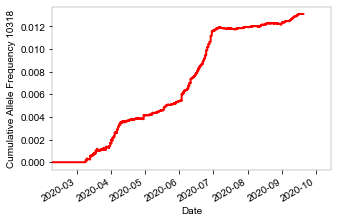

Saved to ./figures/dumpster/all_freqs_oct/11082.png


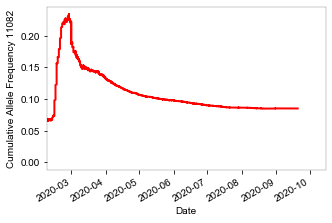

Saved to ./figures/dumpster/all_freqs_oct/11915.png


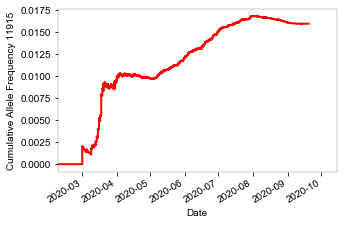

Saved to ./figures/dumpster/all_freqs_oct/13535.png


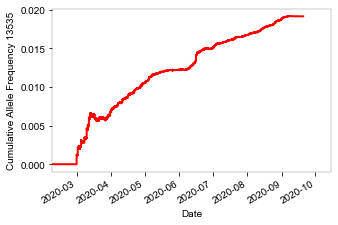

Saved to ./figures/dumpster/all_freqs_oct/13729.png


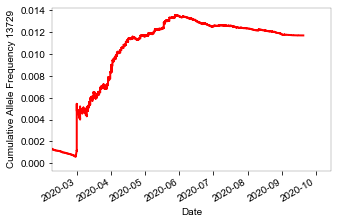

Saved to ./figures/dumpster/all_freqs_oct/14407.png


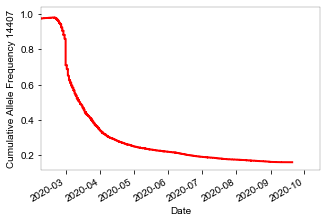

Saved to ./figures/dumpster/all_freqs_oct/14804.png


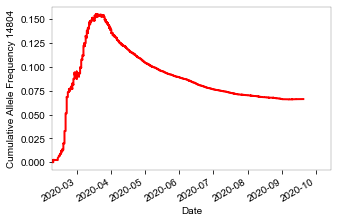

Saved to ./figures/dumpster/all_freqs_oct/15323.png


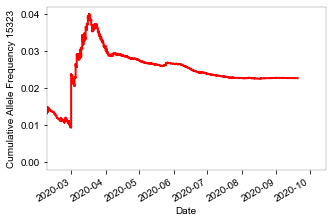

Saved to ./figures/dumpster/all_freqs_oct/16646.png


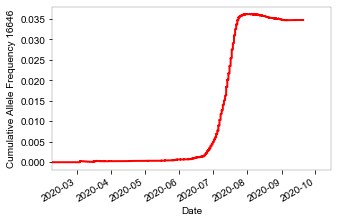

Saved to ./figures/dumpster/all_freqs_oct/17246.png


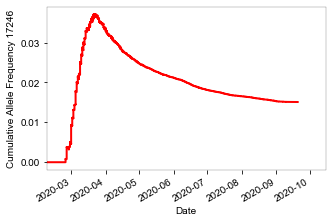

Saved to ./figures/dumpster/all_freqs_oct/17746.png


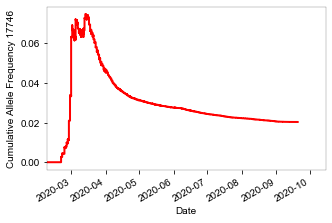

Saved to ./figures/dumpster/all_freqs_oct/17857.png


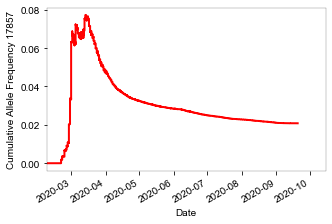

Saved to ./figures/dumpster/all_freqs_oct/18059.png


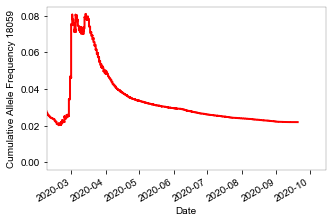

Saved to ./figures/dumpster/all_freqs_oct/18554.png


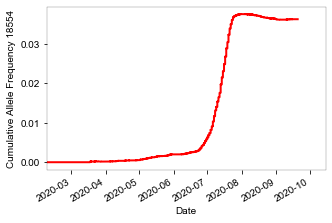

Saved to ./figures/dumpster/all_freqs_oct/18876.png


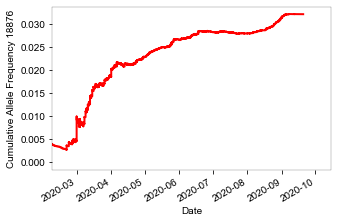

Saved to ./figures/dumpster/all_freqs_oct/19838.png


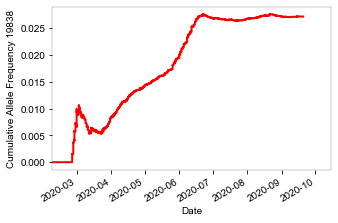

Saved to ./figures/dumpster/all_freqs_oct/20267.png


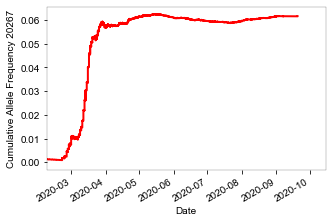

Saved to ./figures/dumpster/all_freqs_oct/21254.png


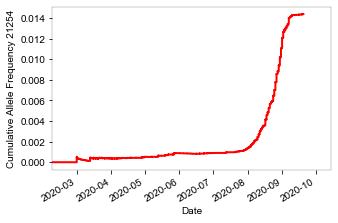

Saved to ./figures/dumpster/all_freqs_oct/22226.png


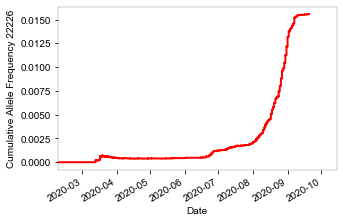

Saved to ./figures/dumpster/all_freqs_oct/22479.png


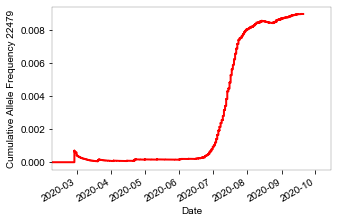

Saved to ./figures/dumpster/all_freqs_oct/22991.png


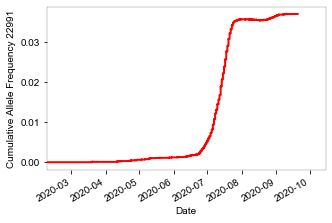

Saved to ./figures/dumpster/all_freqs_oct/23400.png


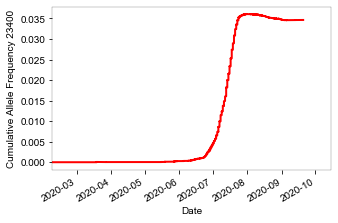

Saved to ./figures/dumpster/all_freqs_oct/23402.png


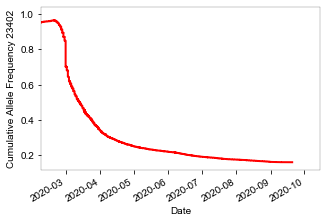

Saved to ./figures/dumpster/all_freqs_oct/23730.png


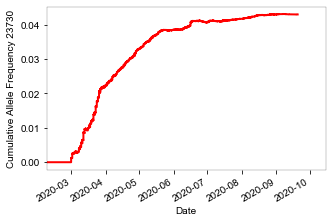

Saved to ./figures/dumpster/all_freqs_oct/25428.png


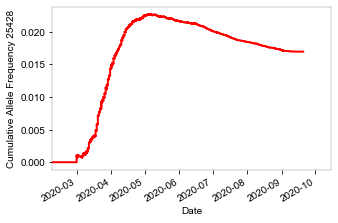

Saved to ./figures/dumpster/all_freqs_oct/25562.png


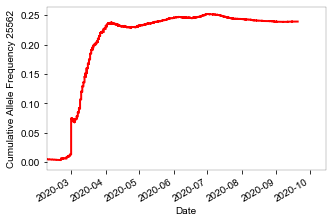

Saved to ./figures/dumpster/all_freqs_oct/25978.png


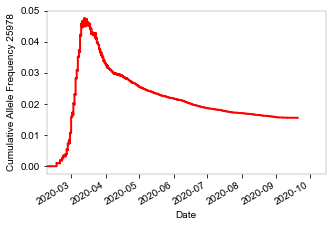

Saved to ./figures/dumpster/all_freqs_oct/26143.png


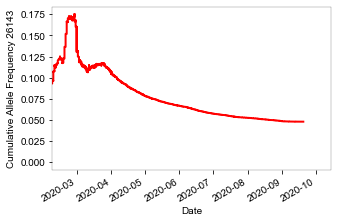

Saved to ./figures/dumpster/all_freqs_oct/26734.png


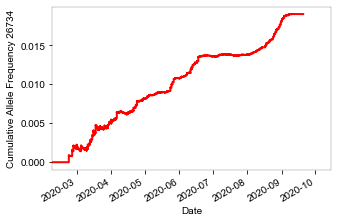

Saved to ./figures/dumpster/all_freqs_oct/26800.png


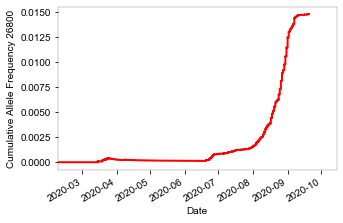

Saved to ./figures/dumpster/all_freqs_oct/27963.png


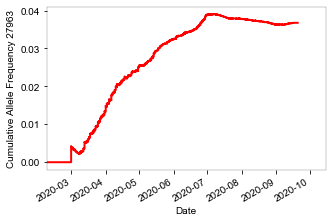

Saved to ./figures/dumpster/all_freqs_oct/28143.png


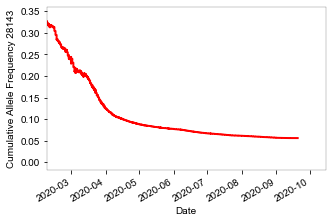

Saved to ./figures/dumpster/all_freqs_oct/28310.png


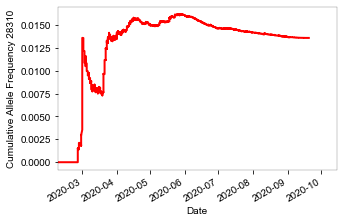

Saved to ./figures/dumpster/all_freqs_oct/28579.png


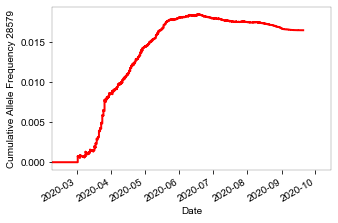

Saved to ./figures/dumpster/all_freqs_oct/28656.png


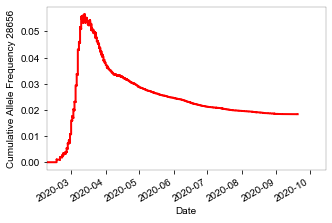

Saved to ./figures/dumpster/all_freqs_oct/28853.png


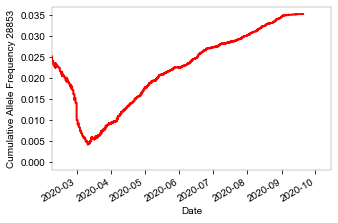

Saved to ./figures/dumpster/all_freqs_oct/28862.png


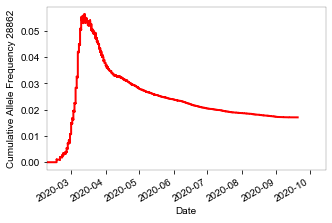

Saved to ./figures/dumpster/all_freqs_oct/28880.png


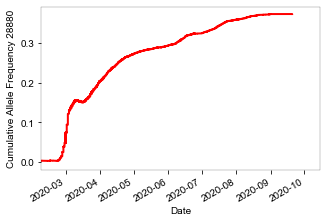

Saved to ./figures/dumpster/all_freqs_oct/28881.png


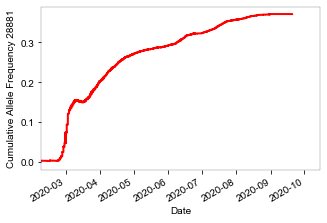

Saved to ./figures/dumpster/all_freqs_oct/28882.png


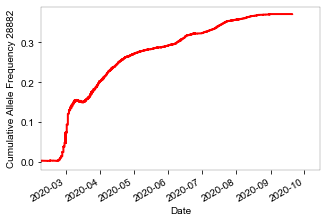

Saved to ./figures/dumpster/all_freqs_oct/28931.png


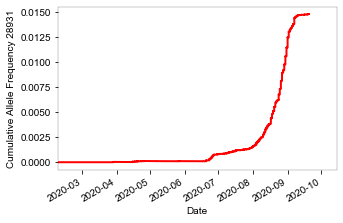

Saved to ./figures/dumpster/all_freqs_oct/29644.png


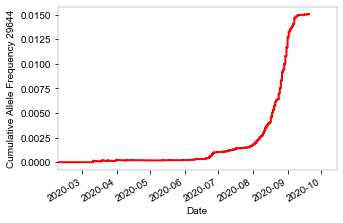

Saved to ./figures/dumpster/all_freqs_oct/29733.png


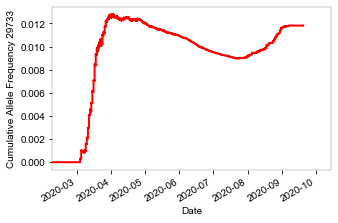

In [26]:
df2 = df1.copy()
flip = True

df2 = df2[df2["date1"]!="2020-01-01"]
df2 = df2.sort_values(by="date1")
df2 = df2[df2['host']=="Human"]
print(f"Human Samples: {len(df2)}")
dts = df2["date1"]
cum_count = np.arange(len(df2))+1

for pos in df["pos"]:
    derived = df2[f"{pos}"]
    cum_der = np.cumsum(derived)
    all_freq = cum_der / cum_count
    
    plt.figure(figsize=(5,3))
    ax=plt.gca()
    ax.plot(dts, all_freq, lw=2, c="r")

    ax.set_ylabel(f"Cumulative Allele Frequency {pos}")
    ax.set_xlabel("Date")
    plt.xticks(rotation=30, ha='right')
    #ax.set_xlim([date("2020-02-01"), date("2020-04-01")])
    ax.set_xlim([date(2020, 2, 8), date(2020, 10, 15)])
    savepath=f"./figures/dumpster/all_freqs_oct/{pos}.png"

    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', 
                    pad_inches = 0, dpi=200)
        print(f"Saved to {savepath}")

    plt.show()

In [22]:
df2

,iid,iid_clean,cov,include,aligned_path,240,312,444,1058,1162,...,pangolin_lineage,GISAID_clade,originating_lab,submitting_lab,authors,url,title,paper_url,date_submitted,date1
3,Wuhan|IPBCAMS-WH-01|2019,Wuhan.IPBCAMS-WH-01.2019,29899,True,./output/singleseq_aligned/Wuhan.IPBCAMS-WH-01...,True,False,False,False,False,...,B,L,"Institute of Pathogen Biology, Chinese Academy...","Institute of Pathogen Biology, Chinese Academy...",Lili Ren et al,https://www.gisaid.org,?,?,2020-01-11,2019-12-24
5,Wuhan|Hu-1|2019,Wuhan.Hu-1.2019,29903,True,./output/singleseq_aligned/Wuhan.Hu-1.2019.fasta,True,False,False,False,False,...,B,L,National Institute for Communicable Disease Co...,National Institute for Communicable Disease Co...,Zhang et al,https://www.gisaid.org,A new coronavirus associated with human respir...,https://dx.doi.org/10.1038/s41586-020-2008-3,2020-01-12,2019-12-26
47,Wuhan|WH01|2019,Wuhan.WH01.2019,29866,True,./output/singleseq_aligned/Wuhan.WH01.2019.fasta,True,False,False,False,False,...,B,L,General Hospital of Central Theater Command of...,"BGI & Institute of Microbiology, Chinese Acade...",Weijun Chen et al,https://www.gisaid.org,Genomic characterisation and epidemiology of 2...,https://dx.doi.org/10.1016/S0140-6736(20)30251-8,2020-01-30,2019-12-26
0,Wuhan|IVDC-HB-01|2019,Wuhan.IVDC-HB-01.2019,29891,True,./output/singleseq_aligned/Wuhan.IVDC-HB-01.20...,True,False,False,False,False,...,B,L,National Institute for Viral Disease Control a...,National Institute for Viral Disease Control a...,Wenjie Tan et al,https://www.gisaid.org,A Novel Coronavirus from Patients with Pneumon...,https://dx.doi.org/10.1056/NEJMoa2001017,2020-01-10,2019-12-30
15047,Wuhan|IVDC-HB-GX02|2019,Wuhan.IVDC-HB-GX02.2019,29892,True,./output/singleseq_aligned/Wuhan.IVDC-HB-GX02....,True,False,False,False,False,...,B,L,National Institute for Viral Disease Control a...,National Institute for Viral Disease Control a...,Wenjie Tan et al,https://www.gisaid.org,?,?,2020-04-28,2019-12-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113140,England|NOTT-113564|2020,England.NOTT-113564.2020,29780,True,./output/singleseq_aligned/England.NOTT-113564...,False,False,True,False,False,...,B.1.79,G,"Queens Medical Centre, Clinical Microbiology D...",COVID-19 Genomics UK (COG-UK) Consortium,Gemma Clark et al,https://www.gisaid.org,?,?,2020-09-28,2020-09-20
113141,England|NOTT-113573|2020,England.NOTT-113573.2020,29782,True,./output/singleseq_aligned/England.NOTT-113573...,False,False,True,False,False,...,B.1,G,"Queens Medical Centre, Clinical Microbiology D...",COVID-19 Genomics UK (COG-UK) Consortium,Gemma Clark et al,https://www.gisaid.org,?,?,2020-09-28,2020-09-20
113142,England|NOTT-113582|2020,England.NOTT-113582.2020,29780,True,./output/singleseq_aligned/England.NOTT-113582...,False,False,True,False,False,...,B.1,G,"Queens Medical Centre, Clinical Microbiology D...",COVID-19 Genomics UK (COG-UK) Consortium,Gemma Clark et al,https://www.gisaid.org,?,?,2020-09-28,2020-09-20
113143,England|NOTT-113591|2020,England.NOTT-113591.2020,29780,True,./output/singleseq_aligned/England.NOTT-113591...,False,False,False,False,False,...,B.1.1,GR,"Queens Medical Centre, Clinical Microbiology D...",COVID-19 Genomics UK (COG-UK) Consortium,Gemma Clark et al,https://www.gisaid.org,?,?,2020-09-28,2020-09-20


In [ ]:




plt.figure(figsize=(5,3))
ax=plt.gca()
ax.plot(dts, all_freq, lw=2, c="r")

ax.set_ylabel(f"Cumulative Allele Frequency {23402}")
ax.set_xlabel("Date")
plt.xticks(rotation=30, ha='right')
#ax.set_xlim([date("2020-02-01"), date("2020-04-01")])
ax.set_xlim([date(2020, 2, 8), date(2020, 4, 25)])
savepath=f"./figures/dumpster/all_freqs_oct{}.png"

if len(savepath)>0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=200)
    print(f"Saved to {savepath}")

plt.show()